# 1. Load the data

## How we do it in R
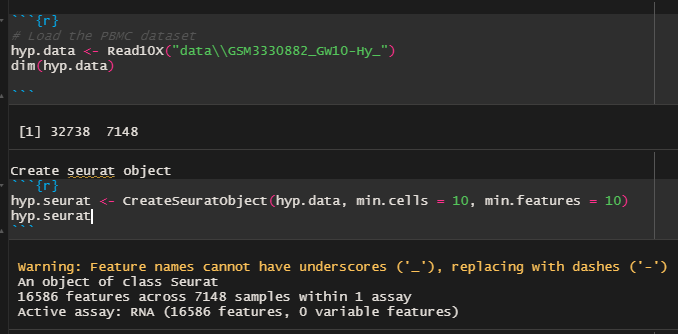

## How we do it in python

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

### Load 10x data into an AnnData object

In [14]:
adata = sc.read_10x_mtx(
    '/home/alevtina/Downloads/gse/1',  # the directory with the `.mtx` file
    var_names='gene_symbols',                # use gene symbols for the variable names (variables-axis index)
    cache=True)                              # write a cache file for faster subsequent reading

### Basic filtering

In [ ]:
sc.pp.filter_cells(adata, min_genes=10)
sc.pp.filter_genes(adata, min_cells=10)

In [ ]:
adata

### AnnData structure
 
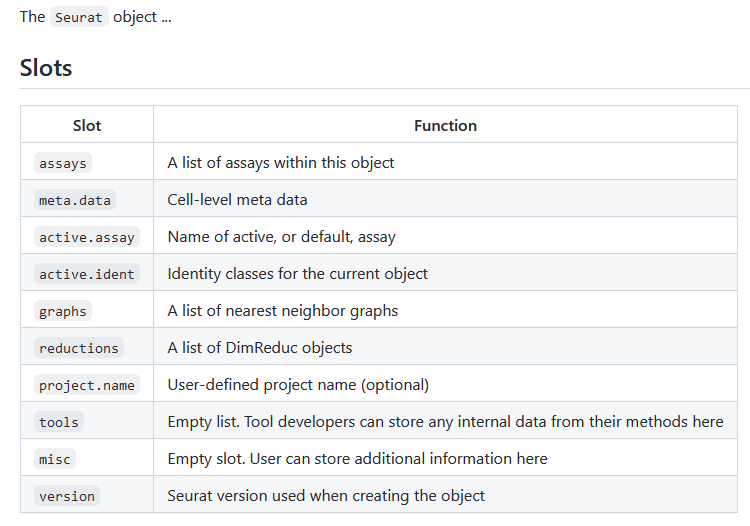 | 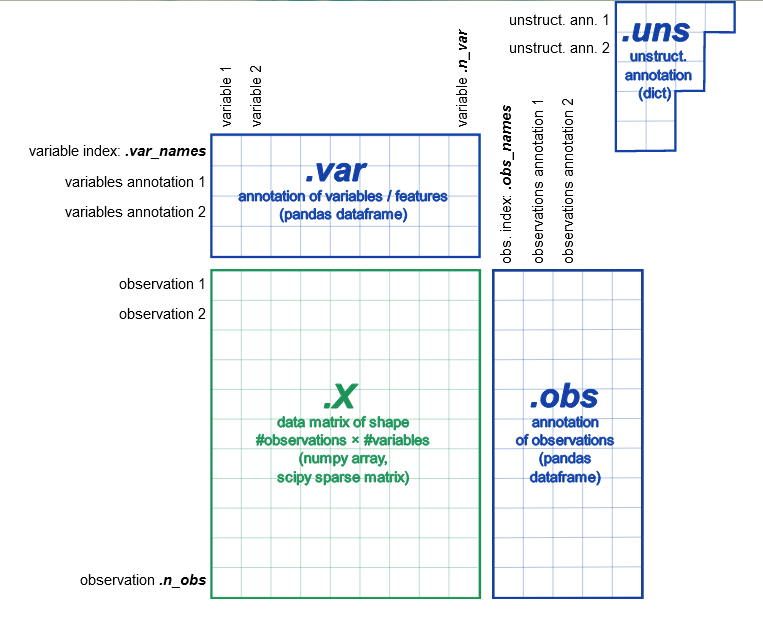

Convert https://github.com/LuckyMD/Code_snippets/blob/master/Seurat_to_anndata.ipynb

## Genes

In [ ]:
adata.var

In [ ]:
adata.var_names

## Observations

In [ ]:
adata.obs.head(10)

## Unstructured data

In [ ]:
adata.uns

## Matrix

In [ ]:
adata.X

In [ ]:
sc.pl.highest_expr_genes(adata, n_top=20, )

# 2. Visualize and filter out poor-quality cells
High portions of MT DNA indicates poor quality cells. We want to delete such cells

## How we do it in R
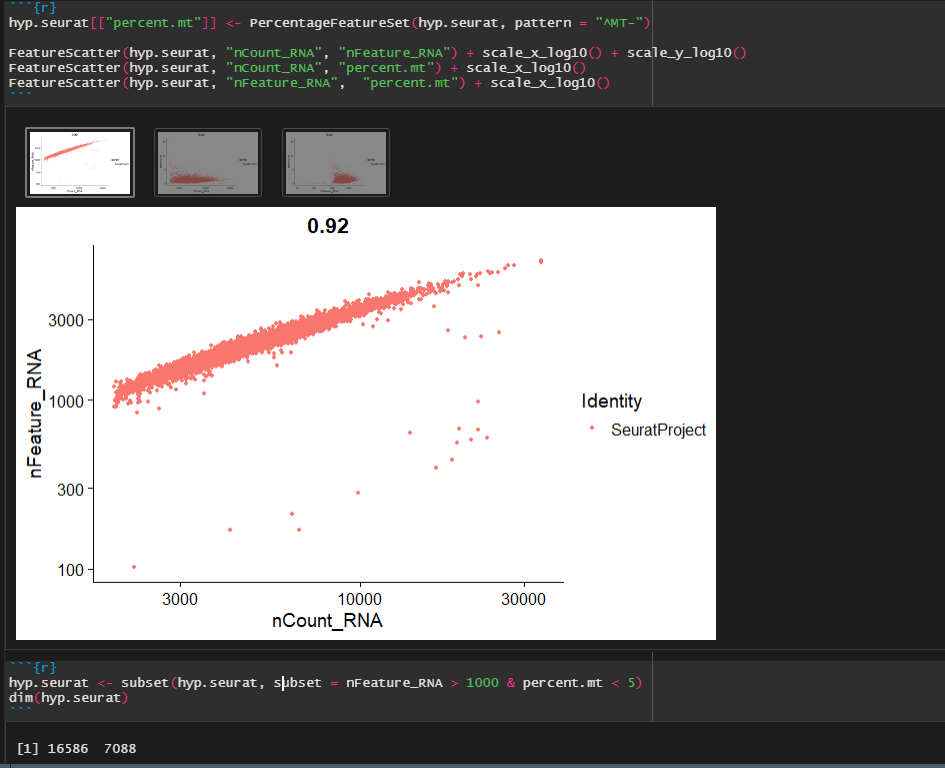
## How we do it in Python

In [ ]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')  # annotate the group of mitochondrial genes as 'mt'
adata.var

In [ ]:
adata.var['mt'].value_counts()

In [ ]:
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=True, inplace=True)

In [ ]:
# “n_genes_by_counts”. The number of genes with at least 1 count in a cell. Calculated for all cells.
# “total_counts”. Total number of counts for a cell.

adata.obs

In [ ]:
#“pct_dropout_by_counts”. Percentage of cells this feature does not appear in.
#“n_cells_by_counts”. Number of cells this expression is measured in.
# “mean_counts”. Mean expression over all cells.
#  “total_counts”. Sum of counts for a gene.
adata.var

In [ ]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')
sc.pl.scatter(adata, x='n_genes_by_counts', y='pct_counts_mt')

In [ ]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'],
             jitter=0.4, multi_panel=True)

In [ ]:
adata = adata[adata.obs.n_genes_by_counts > 1000, :].copy()
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()

adata

In [ ]:
import scanpy as sc
import seaborn as sns

sns.jointplot(
    data=adata.obs,
    x="total_counts",
    y="n_genes_by_counts",
    kind="hex",
)

# 3. Normalize and scale the data
## How we do it in R
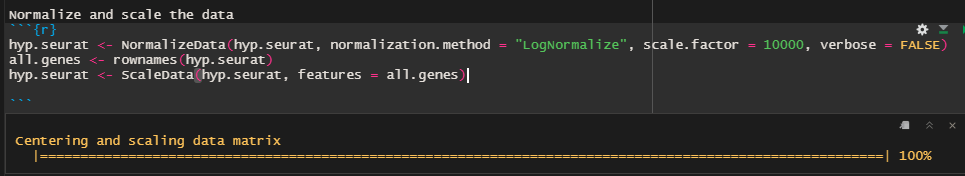
## How we do it in Python

In [ ]:
pd.DataFrame.sparse.from_spmatrix(adata.X[:100, :100])

In [ ]:
sc.pp.normalize_total(adata, target_sum=1e4) # Total-count normalize (library-size correct) the data matrix X to 10,000 reads per cell, so that counts become comparable among cells.
sc.pp.log1p(adata) # log-normalization


In [ ]:
pd.DataFrame.sparse.from_spmatrix(adata.X[:100, :100])

In [ ]:
sc.pl.highest_expr_genes(adata, n_top=20, )

# 4. Identification of highly variable features
## How we do it in R
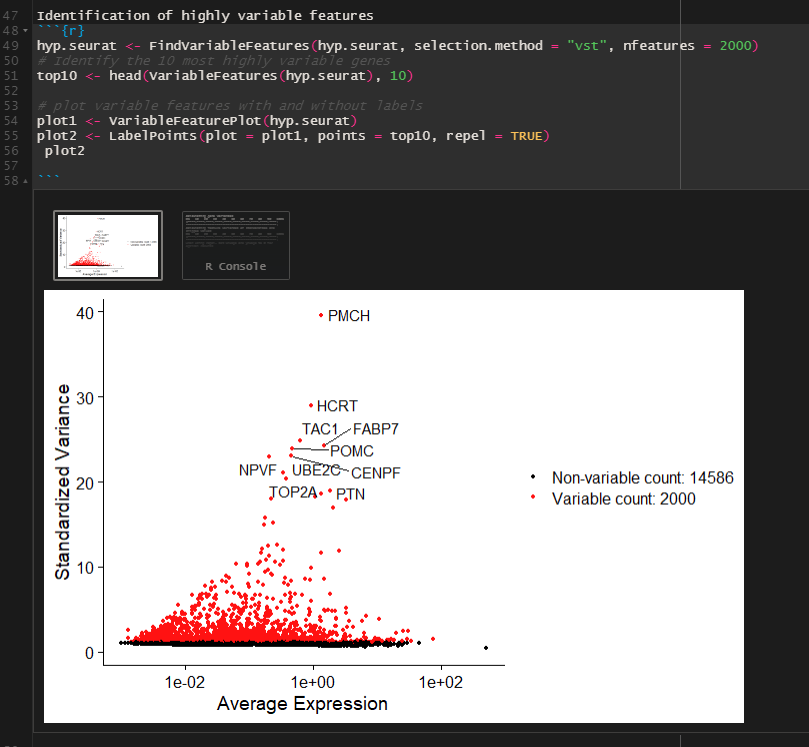
## How we do it in Python

In [ ]:
import matplotlib.pyplot as plt
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
gca = sc.pl.highly_variable_genes(adata, show=False, log=False) # can not scale only x


In [ ]:
adata.var['highly_variable'].value_counts()

# 5. PCA dimensionality reduction
## How we do it in R
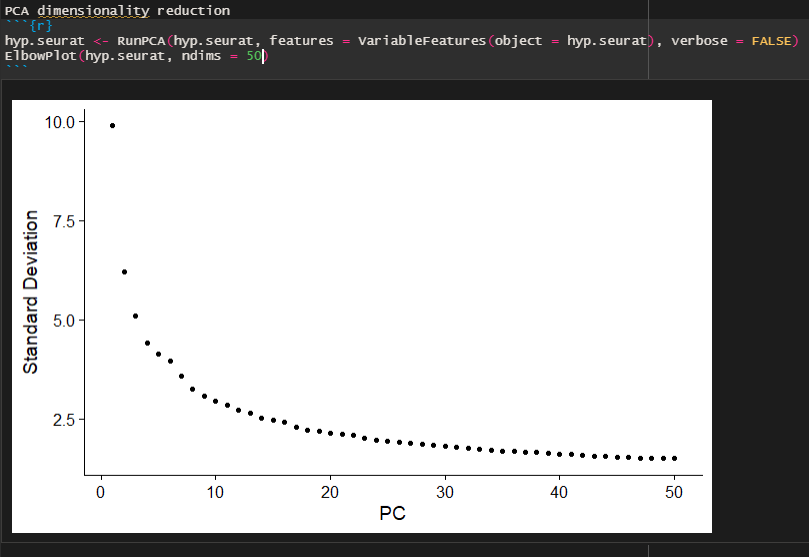
## How we do it in Python

In [ ]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)

In [ ]:
sc.pl.pca(adata, color='CST3')

# 6. Compute neghborhood graph and embedd it using UMAP (non-linear dimensionality reduction)
## How we do it in R
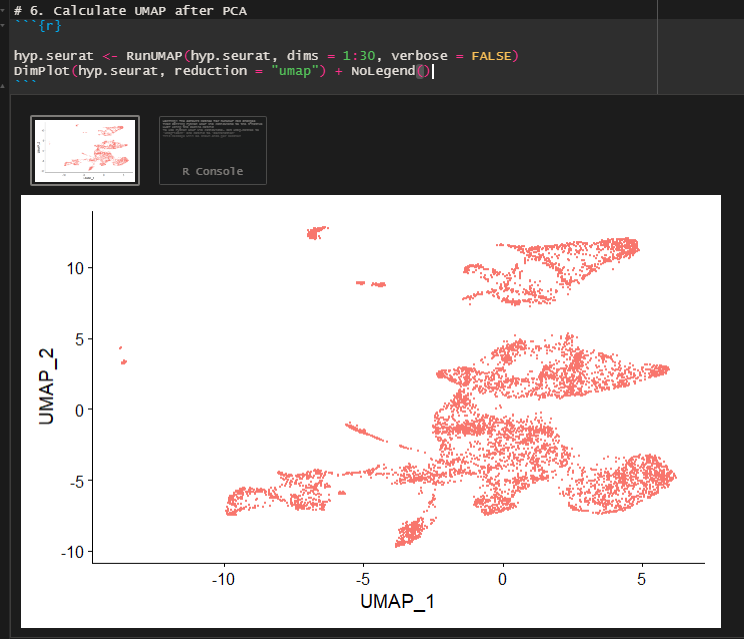
## How we do it in Python
Let us compute the neighborhood graph of cells using the PCA representation of the data matrix. You might simply use default values here. For the sake of reproducing Seurat’s results, let’s take the following values.

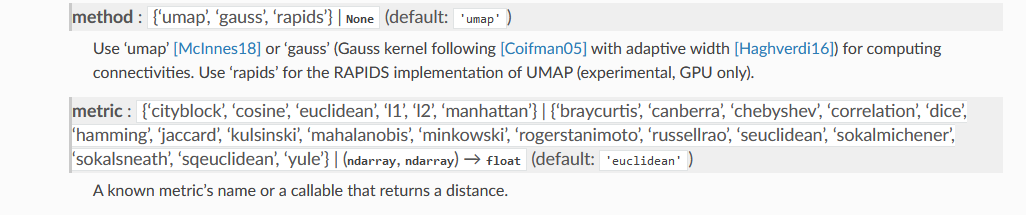

In [ ]:
sc.pp.neighbors(adata, n_neighbors=30, n_pcs=30)
sc.tl.umap(adata)
sc.pl.umap(adata)

# 7. Cell clusters
## How we do it in R
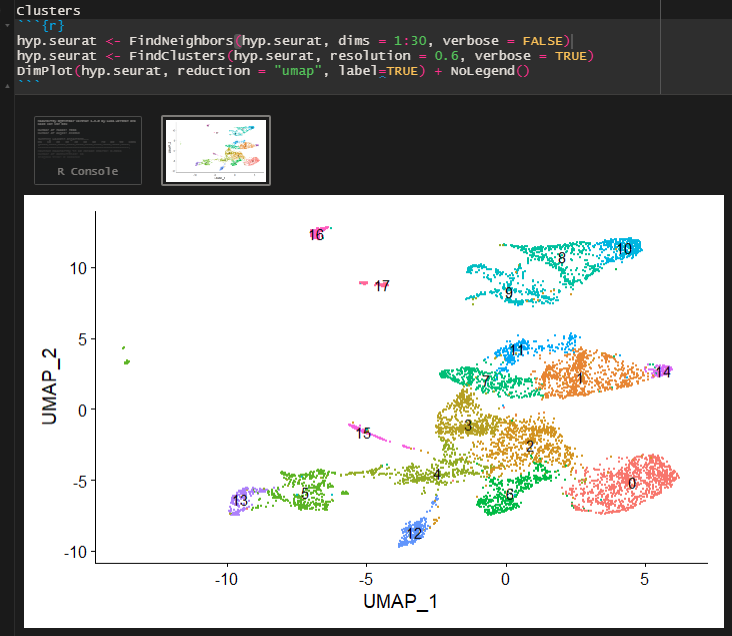
## How we do it in Python


In [ ]:
sc.tl.louvain(adata, resolution=1.2)
sc.pl.umap(adata, color='louvain')

# 8. Visualizing gene expression in clusters
## How we do it in R
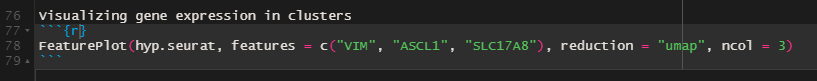
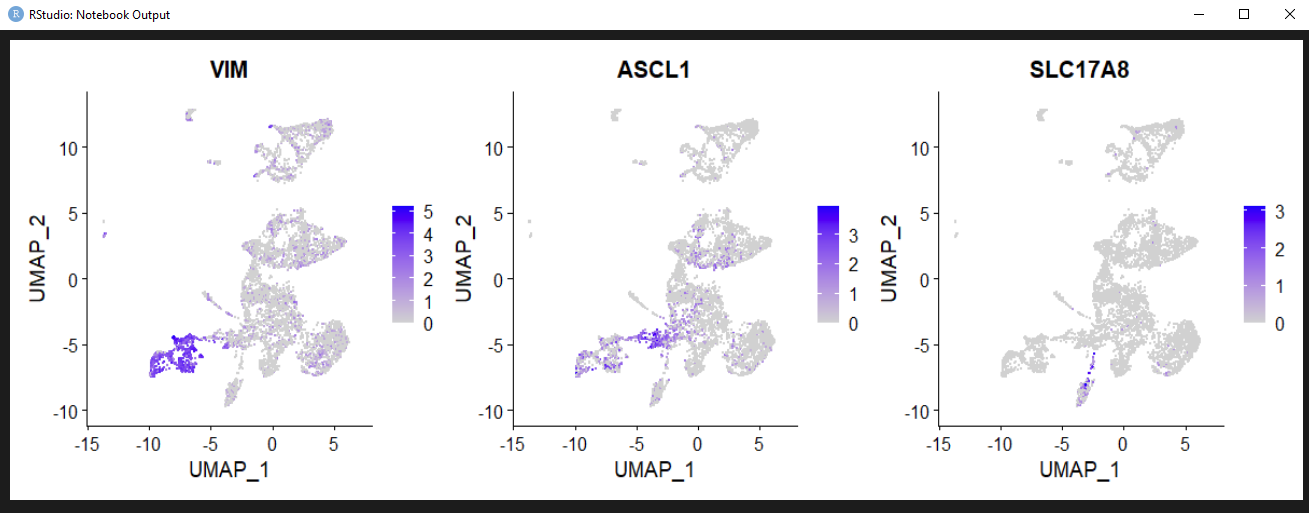
## How we do it in Python

In [ ]:
sc.pl.umap(adata, color=["VIM", "ASCL1", "SLC17A8"])

# 9. Running DGE tests to find cluster biomarkers

## How we do it in R
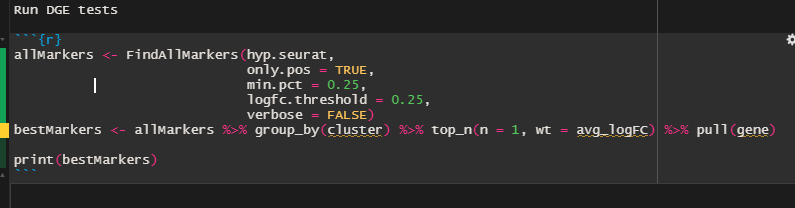

Took infinity to calculate
## How we do it in Python

In [ ]:
sc.tl.rank_genes_groups(adata, 'louvain', method='wilcoxon')
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(1)

In [ ]:
sc.pl.umap(adata, color=["FEZF1", "HES6", "OTP"])

## Another clustering and change size

In [ ]:
from matplotlib.pyplot import rc_context
with rc_context({'figure.figsize': (10, 10)}):
    sc.tl.leiden(adata, resolution=0.7)
    sc.pl.umap(adata, color='leiden', s=20)

## Extract embeddings

In [ ]:
adata.obsm

In [ ]:
df = pd.DataFrame(adata.obsm['X_pca'])

In [ ]:
df

In [ ]:
adata.X

In [ ]:
adata.var

In [ ]:
adata.obs

In [ ]:
adata.uns